This notebook explores the CFD dataset

URL: https://chicagofaces.org/default/

Explanation:

_The database includes high-resolution photographs of 597 male and
female targets of varying ethnicity. Each target is represented with a neutral
expression photo that has been normed by an independent rater sample.
For a subset of 158 targets, the database also includes photos with the following
facial expressions:_

• happy (with open mouth and visible teeth)

• happy (with closed mouth)

• angry

• fearful

_Not all facial expressions are available for each of these 158 targets.
Norming of the facial expression photos is still in progress._ 



(Jargon: target :=  Face model)

There are 3 data assets:

- Images: (597 targets, 1207 images)
- 'cfd_codebook_annotated.csv': (A 597 x 69 data matrix associating 69 variables with regards to the 597 face models used)
- 'cfd_meta_data.csv': Explanation of the 69 variables mined


**File naming convention:**


- CFD-RaceGender-ImageID-TargetID-Expression.jpg
- Race= {A, B, L, W}
- Gender= {F, M}
- Expression= {N,A,F,HC,HO}

Outputs: 
- A numpy tensor of size 1207 x 224 x 224 x 3: 'cfd_pre_proc.npy'
- Plots (all saved in './plots')

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

First, the imports:

In [2]:
%matplotlib inline
import sys
import numpy as np
import cv2 as cv
import tensorflow as tf
# from models import resnet as resnet
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm.notebook import tqdm

Read in the data assets:

In [3]:
data_dir=os.getcwd()+'/data/images/cfd/CFD Version 2.0.3/CFD 2.0.3 Images/'
list_subjects=os.listdir(data_dir)
N_subjects=len(list_subjects)
print(f'The total number of directories associated with each subject: {N_subjects}')
print()
try:
    list_subjects.remove('.DS_Store')
except:
    pass

#####################################
df_targets=pd.read_csv('cfd_meta_data.csv')
#####################################
df_var_explain=pd.read_csv('cfd_codebook_annotated.csv')

The total number of directories associated with each subject: 597



In [4]:
df_targets.head(2)

,Target,Race,Gender,Age,NumberofRaters,Female_prop,Male_prop,Asian_prop,Black_prop,Latino_prop,...,EyeShape,EyeSize,UpperHeadLength,MidfaceLength,ChinLength,ForeheadHeight,CheekboneHeight,CheekboneProminence,FaceRoundness,fWHR
0,AF-200,A,F,32.571429,28,1.0,0.0,1.000000,0.0,0.0,...,0.404651,0.060924,0.414099,0.326797,0.130719,0.264706,0.388189,91.5,0.545752,1.921146
1,AF-201,A,F,23.666667,27,1.0,0.0,0.962963,0.0,0.0,...,0.329204,0.041892,0.414414,0.329279,0.144595,0.300901,0.383784,146.0,0.488288,1.901129


In [5]:
df_var_explain.head(2)

,Variable,Category,Explanation
0,Target,facemodel_ID,target image - first character designates race...
1,Race,facemodel_details,target's self-identified race


# Section-1: The images

In this section, we will explore:
- The demographic statistics of the images collected
- Visualize the average images by the subcategories:

In [6]:
from pathlib import Path
from itertools import islice

space =  '    '
branch = '│   '
tee =    '├── '
last =   '└── '

def tree(dir_path: Path, level: int=-1, limit_to_directories: bool=False,
         length_limit: int=10000):
    """Given a directory Path object print a visual tree structure"""
    dir_path = Path(dir_path) # accept string coerceable to Path
    files = 0
    directories = 0
    def inner(dir_path: Path, prefix: str='', level=-1):
        nonlocal files, directories
        if not level: 
            return # 0, stop iterating
        if limit_to_directories:
            contents = [d for d in dir_path.iterdir() if d.is_dir()]
        else: 
            contents = list(dir_path.iterdir())
        pointers = [tee] * (len(contents) - 1) + [last]
        for pointer, path in zip(pointers, contents):
            if path.is_dir():
                yield prefix + pointer + path.name
                directories += 1
                extension = branch if pointer == tee else space 
                yield from inner(path, prefix=prefix+extension, level=level-1)
            elif not limit_to_directories:
                yield prefix + pointer + path.name
                files += 1
    print(dir_path.name)
    iterator = inner(dir_path, level=level)
    for line in islice(iterator, length_limit):
        print(line)
    if next(iterator, None):
        print(f'... length_limit, {length_limit}, reached, counted:')
    print(f'\n{directories} directories' + (f', {files} files' if files else ''))
tree(Path.home() / data_dir,level=2)

CFD 2.0.3 Images
├── AF-200
│   └── CFD-AF-200-228-N.jpg
├── AF-205
│   └── CFD-AF-205-155-N.jpg
├── AF-207
│   └── CFD-AF-207-023-N.jpg
├── AF-210
│   └── CFD-AF-210-050-N.jpg
├── AF-213
│   └── CFD-AF-213-126-N.jpg
├── AF-214
│   └── CFD-AF-214-139-N.jpg
├── AF-217
│   └── CFD-AF-217-155-N.jpg
├── AF-224
│   └── CFD-AF-224-026-N.jpg
├── AF-227
│   └── CFD-AF-227-207-N.jpg
├── AF-229
│   └── CFD-AF-229-160-N.jpg
├── AF-231
│   └── CFD-AF-231-357-N.jpg
├── AF-232
│   └── CFD-AF-232-078-N.jpg
├── AF-233
│   └── CFD-AF-233-190-N.jpg
├── AF-237
│   └── CFD-AF-237-223-N.jpg
├── AF-240
│   └── CFD-AF-240-206-N.jpg
├── AF-243
│   └── CFD-AF-243-170-N.jpg
├── AF-244
│   └── CFD-AF-244-168-N.jpg
├── AF-253
│   └── CFD-AF-253-130-N.jpg
├── AF-256
│   └── CFD-AF-256-160-N.jpg
├── AM-201
│   └── CFD-AM-201-076-N.jpg
├── AM-211
│   └── CFD-AM-211-052-N.jpg
├── AM-218
│   └── CFD-AM-218-085-N.jpg
├── AM-221
│   └── CFD-AM-221-184-N.jpg
├── AM-232
│   └── CFD-AM-232-251-N.jpg
├── AM-233
│   └── CFD-

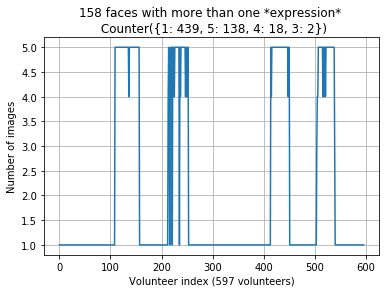

In [7]:
import collections

n_images_user=[]
list_all_images=[]
path_all_images=[]

for i in range(df_targets.shape[0]): # For loop through all the images:
    dir_user=data_dir+df_targets.Target.values[i]+'/'
    list_user_images=os.listdir(dir_user)
    if('.DS_Store' in list_user_images):
        list_user_images.remove('.DS_Store')
    list_all_images.extend(list_user_images)
    path_all_images.extend([dir_user+im for im in list_user_images])

    n_images_user.append(len(list_user_images))
plt.plot(n_images_user)
plt.title(f'{(np.array(n_images_user)>1).sum()} faces with more than one *expression* \n {collections.Counter(n_images_user)}');
plt.ylabel('Number of images')
plt.xlabel('Volunteer index (597 volunteers)')
plt.grid('On')
plt.savefig('./plots/n_images.pdf',bbox_inches = 'tight', pad_inches = 0)

In [8]:
def impath_extract(im):
    """
    
    Helper function to extract all the properties of the image from the file-name
    
    """
    list_name=im.split('/')[-1].split('-')[1:3]
    race_im=list_name[0][0]
    gender_im=list_name[0][1]
    target_im=f'{list_name[0]}-{list_name[1]}'
    r_g_im=list_name[0]
    exprn_im=im.split('/')[-1].split('-')[-1].split('.')[0]
    return np.array([target_im,race_im,gender_im,r_g_im,exprn_im])

def preprocess(img):
    """
    
    Helper function to pre-process images into the ML-images model
    
    """
    rawH = float(img.shape[0])
    rawW = float(img.shape[1])
    newH = 256.0
    newW = 256.0
    test_crop = 224.0 

    if rawH <= rawW:
        newW = (rawW/rawH) * newH
    else:
        newH = (rawH/rawW) * newW
    img = cv.resize(img, (int(newW), int(newH)))
    img = img[int((newH-test_crop)/2):int((newH-test_crop)/2)+int(test_crop),int((newW-test_crop)/2):int((newW-test_crop)/2)+int(test_crop)]
    img = ((img/255.0) - 0.5) * 2.0
    img = img[...,::-1]
    return img

In [9]:
col_list=['Target','race','gender','race_gender','exprn']
df_cfd=pd.DataFrame(columns=col_list)
N_images=len(path_all_images)
####
cfd_raw=np.zeros((N_images,1718, 2444, 3))
cfd_pre_proc=np.zeros((N_images,224,224, 3))
###
nonstandard_shape_list=[]
# This for-looping over the dataset will ensure that there's 
# one-to-one mapping between images & the dataframe entries
for i,im in tqdm(enumerate(path_all_images)):
    raw_img = cv.imread(im)
    try:
        cfd_raw[i]=raw_img
    except:
        print(raw_img.shape)
        nonstandard_shape_list.append(raw_img.shape)
        cfd_raw[i]=cv.resize(raw_img, (2444,1718))
    cfd_pre_proc[i]=preprocess(raw_img)
    df_cfd.loc[i,:]=impath_extract(im) 

(1712, 2436, 3)
(1714, 2444, 3)



 So, all the images are of size: 
 (1718, 2444, 3), (1712, 2436, 3) or (1714, 2444, 3)


In [10]:
# np.save('cfd_raw.npy',cfd_raw)
np.save('cfd_pre_proc.npy',cfd_pre_proc)

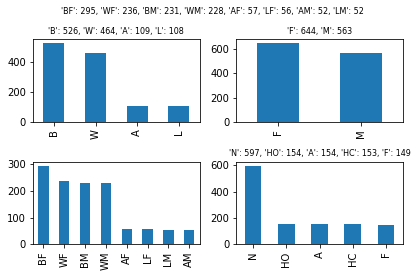

In [11]:
plt.plot(figsize=(15,6))
plt.subplot(221)
df_cfd.race.value_counts().plot(kind='bar')
plt.title(str(collections.Counter(df_cfd.race)).split('{')[1].split('}')[0],fontsize=8);

plt.subplot(222)
df_cfd.gender.value_counts().plot(kind='bar')
plt.title(str(collections.Counter(df_cfd.gender)).split('{')[1].split('}')[0],fontsize=8);


plt.subplot(223)
df_cfd.race_gender.value_counts().plot(kind='bar')
# plt.title(str(collections.Counter(df_cfd.race_gender)).split('{')[1].split('}')[0],fontsize=8);

plt.subplot(224)
df_cfd.exprn.value_counts().plot(kind='bar')
plt.title(str(collections.Counter(df_cfd.exprn)).split('{')[1].split('}')[0],fontsize=8);
plt.suptitle(str(collections.Counter(df_cfd.race_gender)).split('{')[1].split('}')[0],fontsize=8);
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./plots/stats_cfd.pdf',bbox_inches = 'tight', pad_inches = 0)

AF 57
AM 52
BF 295
BM 231
LF 56
LM 52
WF 236
WM 228


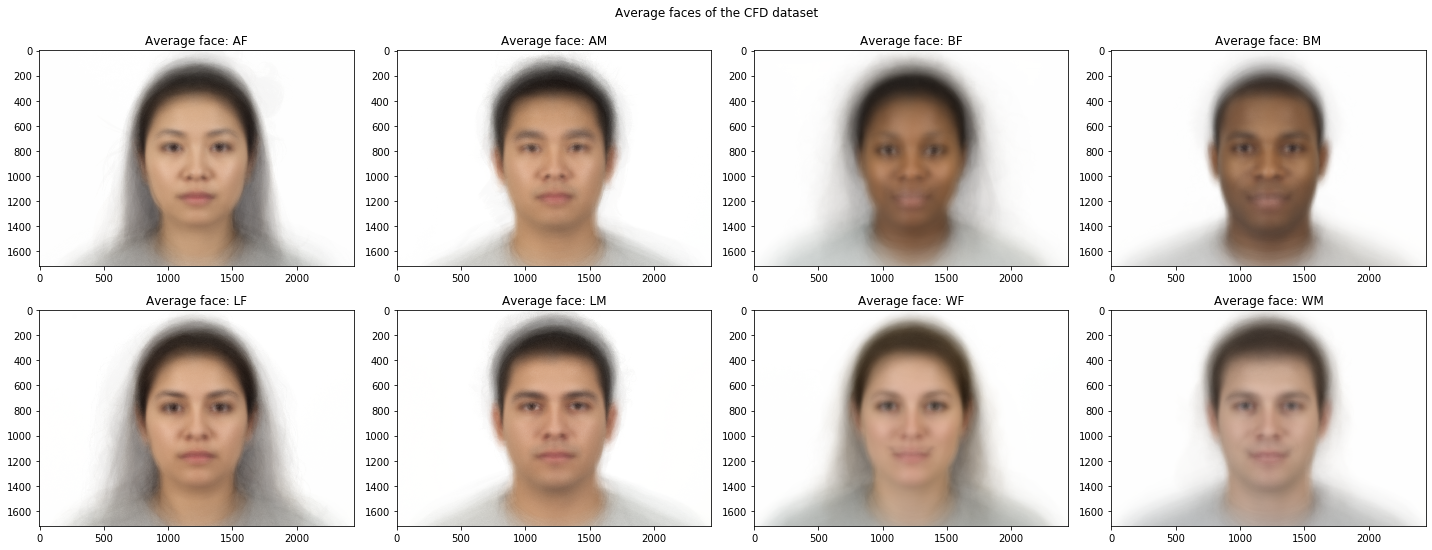

In [12]:
r_g_list=df_cfd.race_gender.unique()
ind_sp=1
plt.figure(figsize=(20,8))
for r_g in r_g_list:
    ind_rg=np.where(df_cfd.loc[:,'race_gender']==r_g)[0]
    print(r_g,len(ind_rg))
    avg_img=np.zeros((1718, 2444, 3))
    for ind in ind_rg:
        avg_img+=cfd_raw[ind]
    avg_img=avg_img/len(ind_rg)
    plt.subplot(2,4,ind_sp)
    plt.imshow(avg_img.astype(int)[...,::-1],aspect='auto')
    # plt.axis('Off')
    
    ind_sp+=1
    plt.title(f'Average face: {r_g}')
plt.suptitle('Average faces of the CFD dataset')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./plots/meanface_cfd.pdf',bbox_inches = 'tight', pad_inches = 0)
plt.savefig('./plots/meanface_cfd.png',dpi=300,bbox_inches = 'tight', pad_inches = 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AF 57
AM 52
BF 295
BM 231
LF 56
LM 52
WF 236
WM 228


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


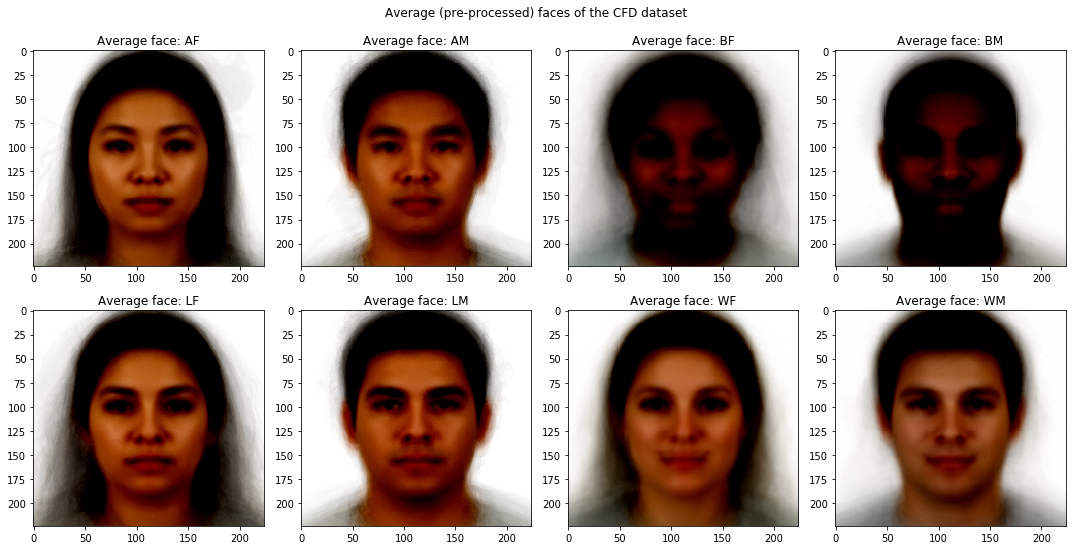

In [13]:
import warnings
warnings.filterwarnings('ignore')
r_g_list=df_cfd.race_gender.unique()
ind_sp=1
plt.figure(figsize=(15,8))
for r_g in r_g_list:
    ind_rg=np.where(df_cfd.loc[:,'race_gender']==r_g)[0]
    print(r_g,len(ind_rg))
    avg_img=np.zeros((224, 224, 3))
    for ind in ind_rg:
        avg_img+=cfd_pre_proc[ind]
    avg_img=avg_img/len(ind_rg)
    plt.subplot(2,4,ind_sp)
    plt.imshow(avg_img,aspect='auto');
    # plt.axis('Off')
    
    ind_sp+=1
    plt.title(f'Average face: {r_g}')
plt.suptitle('Average (pre-processed) faces of the CFD dataset')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./plots/meanface_cfd_preproc.pdf',bbox_inches = 'tight', pad_inches = 0)
plt.savefig('./plots/meanface_cfd_preproc.png',dpi=300,bbox_inches = 'tight', pad_inches = 0)

# Section-2: The meta-data from the subjective measurements:

In [14]:
df_var_explain=pd.read_csv('cfd_codebook_annotated.csv')
df_targets=pd.read_csv('cfd_meta_data.csv')

len(list_subjects),df_targets.shape,df_var_explain.shape,

(597, (597, 69), (69, 3))

In [15]:
df_var_explain

,Variable,Category,Explanation
0,Target,facemodel_ID,target image - first character designates race...
1,Race,facemodel_details,target's self-identified race
2,Gender,facemodel_details,target gender
3,Age,facemodel_details,Estimate the approximate age of this person (i...
4,NumberofRaters,rater_details,number of respondents upon which norming data ...
5,Female_prop,rater_details,number of participants who indicated male gend...
6,Male_prop,rater_details,number of participants who indicated female ge...
7,Asian_prop,rater_details,number of participants who indicated Asian rac...
8,Black_prop,rater_details,number of participants who indicated Black rac...
9,Latino_prop,rater_details,number of participants who indicated Hispanic/...


## Who were the raters?

A convenience sample of 1087 raters made subjective ratings of the standardized neutral faces. Participants included 552 females and 308 males (227 did not report) and came from diverse racial backgrounds (516 White, 117 Asian, 74 Black, 72 biracial or multiracial, 57 Latino, 18 other, and 233 did not report). The average age of the sample was 26.75 (SD = 10.54).

In [18]:
df_targets.head()

,Target,Race,Gender,Age,NumberofRaters,Female_prop,Male_prop,Asian_prop,Black_prop,Latino_prop,...,EyeShape,EyeSize,UpperHeadLength,MidfaceLength,ChinLength,ForeheadHeight,CheekboneHeight,CheekboneProminence,FaceRoundness,fWHR
0,AF-200,A,F,32.571429,28,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.404651,0.060924,0.414099,0.326797,0.130719,0.264706,0.388189,91.5,0.545752,1.921146
1,AF-201,A,F,23.666667,27,1.000000,0.000000,0.962963,0.000000,0.000000,...,0.329204,0.041892,0.414414,0.329279,0.144595,0.300901,0.383784,146.0,0.488288,1.901129
2,AF-202,A,F,24.448276,29,0.827586,0.172414,0.310345,0.068966,0.137931,...,0.357939,0.051586,0.411080,0.310317,0.173424,0.298475,0.397029,58.0,0.481333,1.888249
3,AF-203,A,F,22.758621,29,1.000000,0.000000,0.758621,0.000000,0.068966,...,0.443200,0.063913,0.354407,0.343793,0.169820,0.272266,0.421089,87.5,0.500231,1.863719
4,AF-204,A,F,30.137931,29,1.000000,0.000000,0.827586,0.000000,0.068966,...,0.432247,0.053435,0.438931,0.293045,0.180237,0.293893,0.371925,73.5,0.513571,1.935783


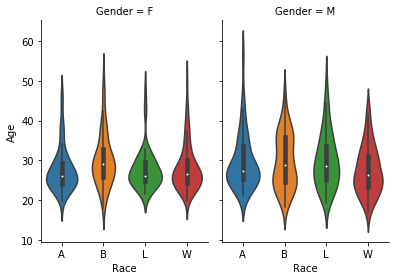

In [19]:
import seaborn as sns
g = sns.catplot(x="Race", y="Age",
                col="Gender",
                data=df_targets, kind="violin", split=True,
                height=4, aspect=.7);

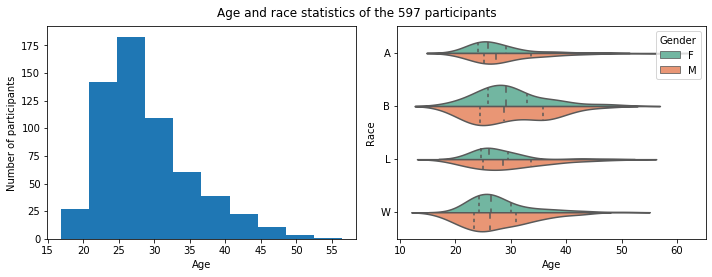

In [20]:
plt.figure(figsize=(10,4))
plt.subplot(122)
ax = sns.violinplot(y="Race", x="Age", hue="Gender",
                    data=df_targets, palette="Set2", split=True,
                    scale="count", inner="quartile", scale_hue=False)
plt.subplot(121)
plt.hist(df_targets.Age)
plt.xlabel('Age')
plt.ylabel('Number of participants')
plt.suptitle('Age and race statistics of the 597 participants')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./plots/n_race_age.pdf',bbox_inches = 'tight', pad_inches = 0)

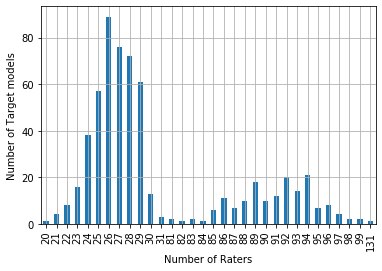

In [21]:
df_targets.NumberofRaters.value_counts(sort=False).plot(kind='bar')
plt.xlabel('Number of Raters')
plt.ylabel('Number of Target models')
plt.grid('On')
plt.savefig('./plots/n_raters.pdf',bbox_inches = 'tight', pad_inches = 0)

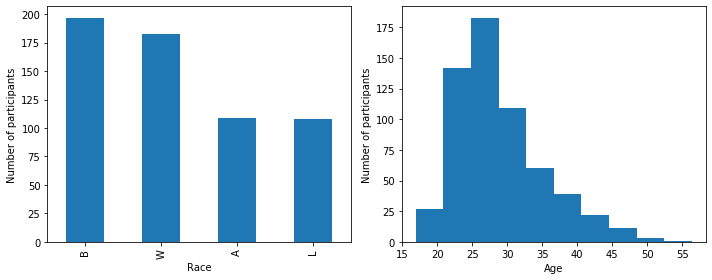

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(121)
df_targets.Race.value_counts().plot(kind='bar')
plt.xlabel('Race')
plt.ylabel('Number of participants')

plt.subplot(122)
plt.hist(df_targets.Age)
plt.xlabel('Age')
plt.ylabel('Number of participants')


plt.tight_layout()
plt.savefig('./plots/n_race_age_0.pdf',bbox_inches = 'tight', pad_inches = 0)

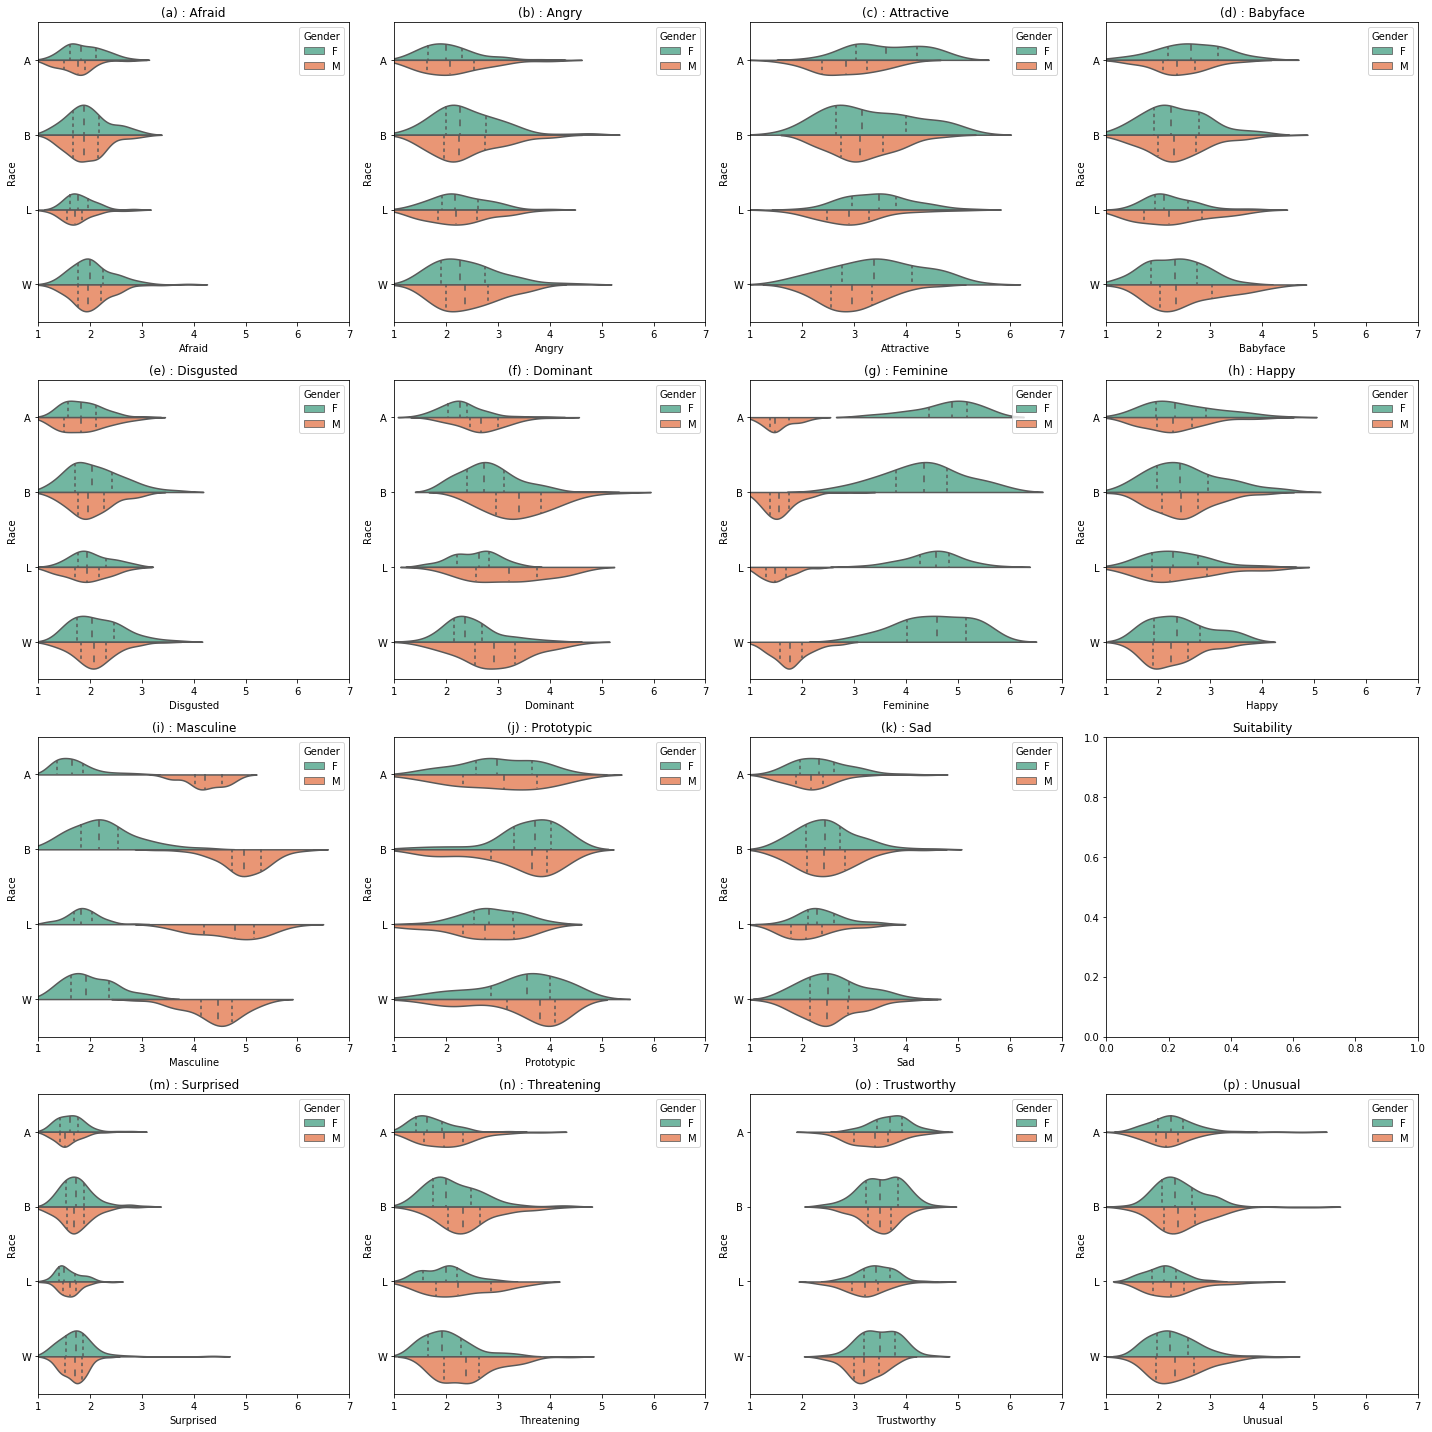

In [23]:
expr_vec=df_var_explain.loc[df_var_explain.Category=='subj_assessmnt'].Variable.values
import string
alphabet_vec=string.ascii_lowercase[:len(expr_vec)]

plt.figure(figsize=(20,20))
for i in range(len(expr_vec)):
    plt.subplot(4,4,i+1)
    try:
        sns.violinplot(y="Race", x=expr_vec[i], hue="Gender",
                    data=df_targets, palette="Set2", split=True,
                    scale="count", inner="quartile", scale_hue=False)
#         plt.title(f'{alphabet_vec[i]} : {df_var_explain.loc[df_var_explain.Variable==expr_vec[i]].Explanation}')
        plt.title(f'({(alphabet_vec[i])}) : {expr_vec[i]}')
        plt.xlim([1,7])
    except:
        plt.title(expr_vec[i])
        pass
plt.tight_layout()
plt.savefig('./plots/express_grid_1.pdf',bbox_inches = 'tight', pad_inches = 0)       

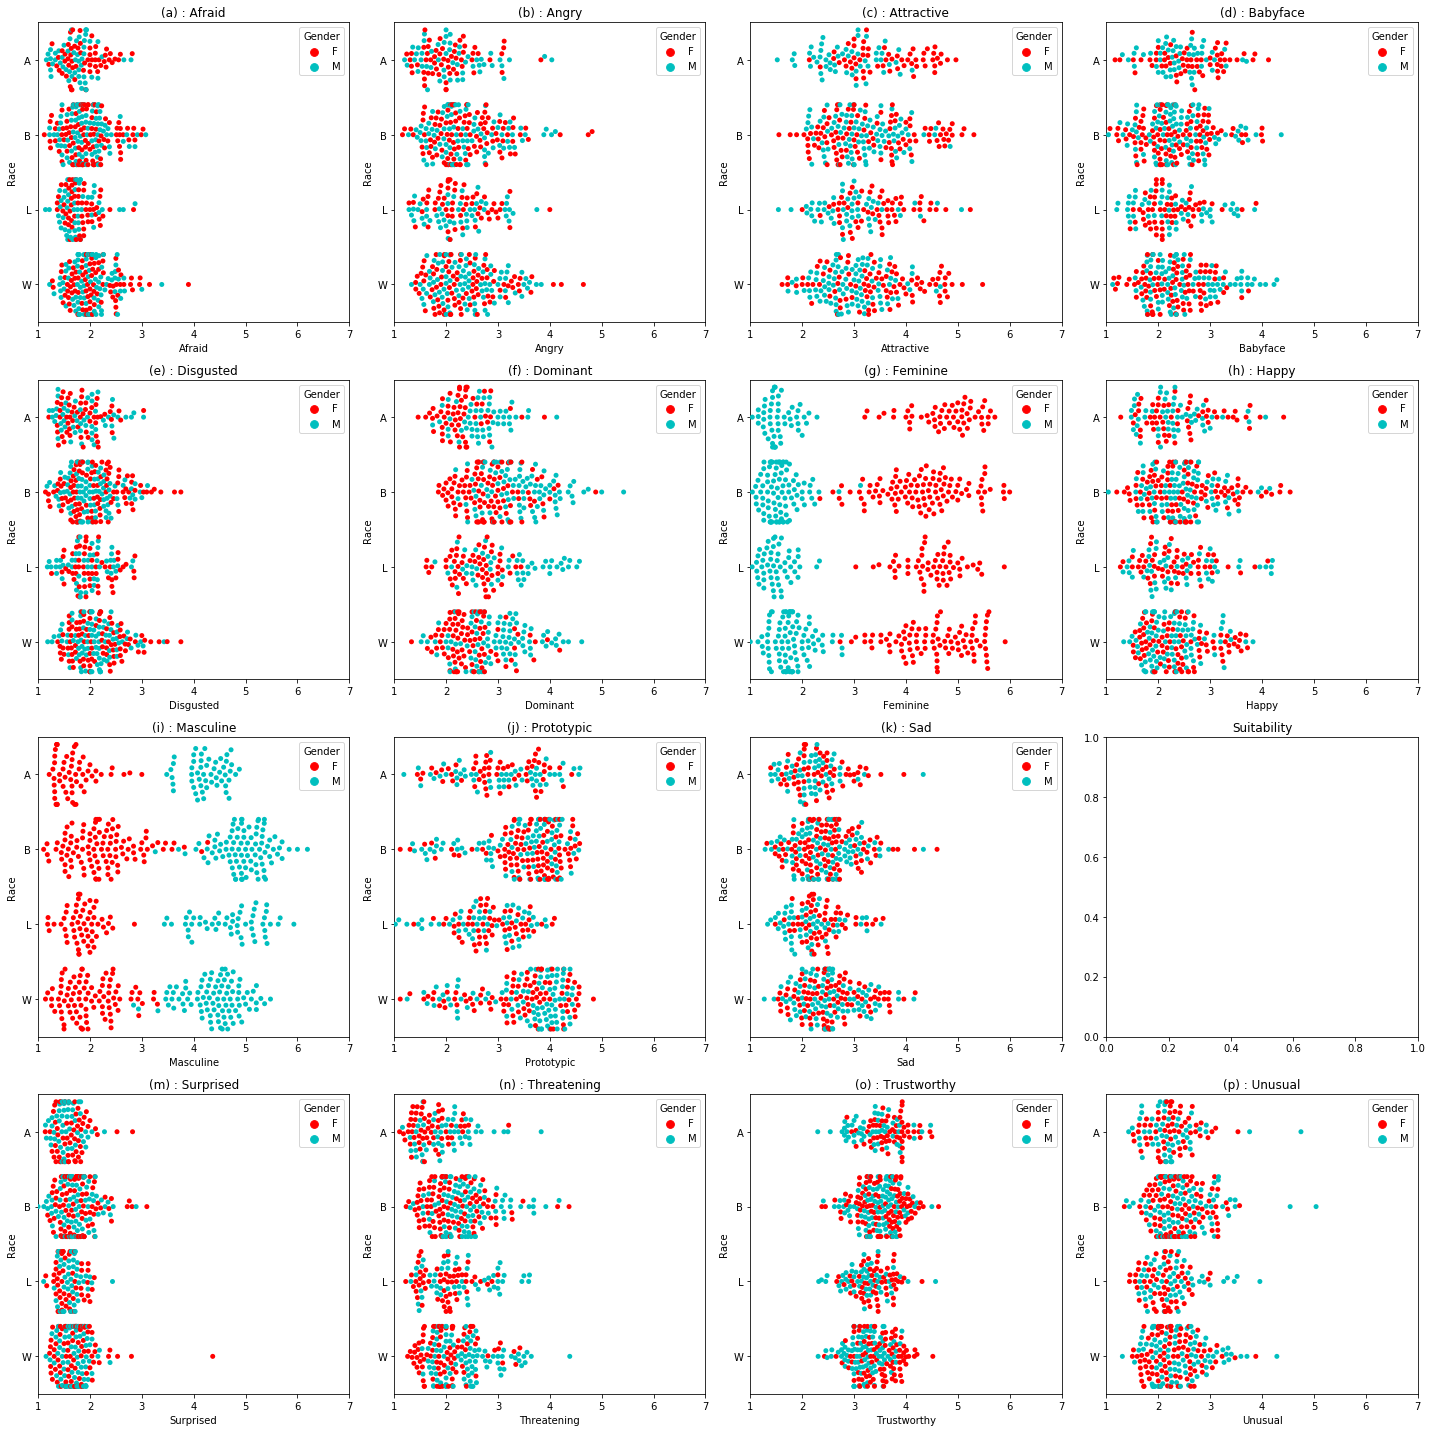

In [24]:
plt.figure(figsize=(20,20))
for i in range(len(expr_vec)):
    plt.subplot(4,4,i+1)
    try:
        sns.swarmplot(x=expr_vec[i], y="Race", hue="Gender",
              palette=["r", "c", "y"], data=df_targets)
        plt.title(f'({alphabet_vec[i]}) : {expr_vec[i]}')
        plt.xlim([1,7])
    except:
        plt.title(expr_vec[i])
        pass
plt.tight_layout()
plt.savefig('./plots/express_grid_2.pdf',bbox_inches = 'tight', pad_inches = 0)  

In [25]:
# !pip install version_information
%load_ext version_information
ver=%version_information

from pip._internal.operations.freeze import freeze
for requirement in freeze(local_only=True):
    print(requirement)
ver

absl-py==0.8.1
alembic==1.3.1
argcomplete==1.10.2
argh==0.26.2
asn1crypto==1.2.0
astor==0.8.0
async-generator==1.10
attrs==19.3.0
backcall==0.1.0
bleach==1.5.0
blinker==1.4
boto==2.49.0
boto3==1.10.21
botocore==1.13.22
cachetools==4.0.0
certifi==2019.11.28
certipy==0.1.3
cffi==1.13.2
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
conda-package-handling==1.6.0
configparser==4.0.2
cryptography==2.8
cudf==0.9.0
cugraph==0.9.0+0.g846190c.dirty
cuml==0.9.1
cupy==6.3.0
cycler==0.10.0
Cython==0.29.14
cytoolz==0.10.1
dask==2.8.0
databricks-cli==0.9.1
decorator==4.4.1
defusedxml==0.6.0
dill==0.2.7.1
docker==4.1.0
docker-pycreds==0.4.0
docutils==0.15.2
entrypoints==0.3
fastavro==0.22.7
fastcache==1.1.0
fastrlock==0.4
Flask==1.1.1
future==0.18.2
gast==0.2.2
gitdb2==2.0.6
GitPython==3.0.5
gmpy2==2.0.8
google-auth==1.10.0
google-auth-oauthlib==0.4.1
google-pasta==0.1.8
gorilla==0.3.0
gql==0.1.0
graphql-core==2.2.1
grpcio==1.16.1
gunicorn==20.0.0
h5py==2.9.0
html5lib==0.9999999
idna==2.8
imageio==2.6.

Software versions
Python 3.6.9 64bit [GCC 7.3.0]
IPython 7.9.0
OS Linux 5.3.0 53 generic x86_64 with debian buster sid
Sun Sep 06 22:48:26 2020 UTC